# Load packages

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

import sympy
from sympy import *
from sympy import symbols, Eq, solve
from shapely.geometry import LineString


%matplotlib inline
import warnings
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick


output = 'Output58'
Input = 'Input21'

# Catchment descriptors

In [2]:
#Function for the Seasonality Index
def Seasonality_index(Annual_mean, Monthly_mean):
    SI = (1/Annual_mean) * np.sum(np.abs(Monthly_mean - (Annual_mean/12)))
    return SI

#Function for Seasonality Timing Index
def ST_calc(dP,dT):
    days = 366
    ST = dP[0] * np.sign(dT[0]) * np.cos((np.pi * (dP[1] - dT[1]))/days)
    return ST

#Functions to compute Seasonal variability indexes
def T_daily(dT):
    t = np.linspace(1,366,366)
    days = 366
    T = T_mean + dT[0] * np.sin((2*np.pi * (t-dT[1]))/days)
    return T

def Cal_T_daily(dT):
    days = 366
    T_calc = T_daily(dT)
    
    return (np.sum(np.abs(T_calc - T_obs)))/days

def P_daily(dP):
    t = np.linspace(1,366,366)
    days = 366
    P = P_mean * (1 + dP[0] * np.sin((2*np.pi * (t-dP[1]))/days))
    return P

def Cal_P_daily(dP):
    days = 366
    P_calc = P_daily(dP)
    
    return (np.sum(np.abs(P_calc - P_obs)))/days

def E_daily(dE):
#    t = np.linspace(1,366,366)
    t = np.linspace(1,366,366)

    days = 366
    E = E_mean * (1 + dE[0] * np.sin((2*np.pi * (t-dE[1]))/days))
    return E

def Cal_E_daily(dE):
    days = 366
    E_calc = E_daily(dE)
    
    return (np.sum(np.abs(E_calc - E_obs)))/days

#Function for the interstorm duration or low_prec_freq
def Interstorm_duration(P):
    interstorm = []
    count = 0

    for j in range(len(P)):
        if P[j] < 1:
            count += 1
        elif P[j] >= 1 and count > 0:
            interstorm.append(count)
            count = 0 
    interstorm_duration = np.mean(interstorm)
    return interstorm_duration



#Function to compute the root-zone storage capacity over total time period
def rootzone(df_out, RP):
    SD = years['SD_sum'].max() - years['SD_sum'].min()
    var = gumbel_r.fit(SD)
    p = 1-1/RP
    Sr = gumbel_r.ppf(p, var[0],var[1])
    return(Sr, df_out)


#Function to compute the potential evaporation for CAMELS-GB
def calc_Makkink_GB(Temp, Rs, timestep = 86400):
    """
    Rs is hier in W/m2
    om van straling unit knmi (J/cm2) naar W/m2 ----> Rs_unit_knmi * 2.77777 
	deze formule is van komt van: https://nl.wikipedia.org/wiki/Referentie-gewasverdamping 
    """
    a = 6.1078
    b = 17.294
    c = 237.73
    Eref = np.zeros(len(Temp))
    for i in range(len(Temp)):
        gamma=0.646+0.0006*Temp[i] 				#psychrometer constante (hPa/C)
        labda=1000*(2501-2.38*Temp[i])			#verdampingswarmte water (J/kg)
        Slope = (a*b*c) / (c+Temp[i])**2 * np.exp(b*Temp[i] / (c+Temp[i]))   # 
        Eref[i] = 0.65 * Slope / (Slope + gamma) * Rs[i] / labda * timestep     #ref verd in mm/h ! 
    return Eref


def w_function(AI, w):
    EI = 1 + AI - (1 + (AI**w))**(1/w)
    return EI

# Catchment selection 

In [3]:
"""
CAMELS-GB: Catchment selection
Check for human influence, if 'Y' this indicates a lot of human influence
Frac_snow < 0.1 means no insignificant snow impact
Saves the catchments to a list
"""

human_influence = pd.read_csv('1_Data\8344e4f3-d2ea-44f5-8afa-86d2987543a9\data\CAMELS_GB_humaninfluence_attributes.csv')
catch_attr = pd.read_csv('1_Data\8344e4f3-d2ea-44f5-8afa-86d2987543a9\data\CAMELS_GB_climatic_attributes.csv')

catchment_list_GB = []
for i in range(len(human_influence)):
    if (human_influence['benchmark_catch'][i] == 'Y')and (catch_attr['frac_snow'][i]<0.1):
        catchment_list_GB.append(human_influence['gauge_id'][i])
        

removing_GB = [42010, 74001, 42016, 65001, 27084, 39101, 44009, 81004, 2002, 66004, 60012, 83010, 90003, 96002, 16003, 18011, 21006, 3003, 27073, 39028, 39065, 42008, 44006, 81002, 85003, 4005, 72014, 83006, 84022, 95001, 73015, 102001, 11004, 13004, 15023, 15025] # the first were because of exceeding of energy limit, the last (6) because of nanvalues for discharge

for i in range(len(removing_GB)):
    catchment_list_GB.remove(removing_GB[i])

# Load data

## Determine time slices

In [4]:
yrcut = [1970, 1980, 1990, 2000, 2010] # het laatste jaar zit er niet in
yrsl = []
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]+1} - {yrcut[i+1]}'
    yrsl.append(sl)
    
print(yrsl)

['1971 - 1980', '1981 - 1990', '1991 - 2000', '2001 - 2010']


## Loop through catchments

In [5]:
warnings.filterwarnings('ignore')
catchment_list = catchment_list_GB
df_output = pd.DataFrame(index=catchment_list)
df_output2 = pd.DataFrame()

for i in range(len(catchment_list)):  
    # Import data and select right dates
    data = pd.read_csv('1_Data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/timeseries/CAMELS_GB_hydromet_timeseries_'+str(catchment_list[i])+str("_19701001-20150930.csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data.loc["1971-01-01":"2010-12-31"]        
        
    # Compute the Makkink potential evaporation
    Eref = calc_Makkink_GB(data['temperature'],data['shortwave_rad'])
    data['Ep_MAK'] = Eref
        
    # Compute mean values    
    Ep = data['Ep_MAK'].mean()    
    T = data['temperature'].mean()
    P  = data['precipitation'].mean()
    Q  = data['discharge_spec'].mean()
        
    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  
    AI = Ep / P   
    EI = Ea / P 
    
    if AI < EI:
        print(f'Exclude catchment with ID (2) {catchment_list[i]}')
    
    # Calculate root zone storage deficits
    RP    = 20 # Return-period of 20 years
    P_ts  = data['precipitation']
    EP_ts = data['Ep_MAK']

    Et = np.zeros(len(P_ts))
    SD = np.zeros(len(P_ts))

    for z in range(len(P_ts)):
        Et[z] = (EP_ts[z]/Ep) * Ea
        if z == 0:
            SD[z] = min(0, P_ts[z] - Et[z])
        else:
            SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
    data.loc[:,'SD'] = SD
            
    data['year'] = pd.DatetimeIndex(data['date']).year
    df_out = pd.DataFrame(index = data.index)
    df_out['hydroyear'] = data['year']
    df_out['SD_sum'] = data['SD']
    Sr = rootzone(df_out,RP)[0]   
    
    #Annual precipitation values
    data_y = data.resample('A').sum()
    Pa = data_y['precipitation'].mean()
    Epa = data_y['Ep_MAK'].mean()
       
    #monthly_mean_values:
    data_m_sum = data.resample('M').sum()
    monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
    P_m_sum = np.zeros(12)
    P_m_sum = monthly_sliced_sum['precipitation']
        
    data_m_mean = data.resample('M').mean()
    monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
    T_m_mean = np.zeros(12)
    T_m_mean = monthly_sliced_mean['temperature']
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temperature'][k])+1):
            T1[count] = daily_sliced_mean['temperature'][k,m]
            P1[count] = daily_sliced_mean['precipitation'][k,m]
            E1[count] = daily_sliced_mean['Ep_MAK'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366
    
    

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    SI = Seasonality_index(Pa, P_m_sum)
    is_dur = Interstorm_duration(data['precipitation'])
    
    
    if AI < EI or Ea < 0:
        print(f'Exclude catchment with ID {catchment_list[i]}')
        
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    
    df_output.loc[catchment_list[i],[f'AI']] = AI
    df_output.loc[catchment_list[i],[f'EI']] = EI
    df_output.loc[catchment_list[i],[f'Pa']] = Pa
    df_output.loc[catchment_list[i],[f'Epa']] = Epa
    df_output.loc[catchment_list[i],[f'T']] = T
    df_output.loc[catchment_list[i],[f'is_dur']] = is_dur
    df_output.loc[catchment_list[i],[f'SI']] = SI
    df_output.loc[catchment_list[i],[f'ST']] = ST
    df_output.loc[catchment_list[i],[f'Sr']] = Sr


    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['date']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        data_past_decades = data.loc[(yrcut[0] <= data['year']) & (data['year'] < yrcut[j+1])]
        # display(data_past_decades)
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_MAK'].mean()    
        T = datanew['temperature'].mean()
        P  = datanew['precipitation'].mean()
        Q  = datanew['discharge_spec'].mean()
        

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
            
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                                
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize=5)
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['precipitation']
        EP_ts = datanew['Ep_MAK']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
            
        datanew['year'] = pd.DatetimeIndex(datanew['date']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        Sr = rootzone(df_out,RP)[0]

        #Annual precipitation values
        data_y = datanew.resample('A').sum()
        Pa = data_y['precipitation'].mean()
        Epa = data_y['Ep_MAK'].mean()
       
        #monthly_mean_values:
        data_m_sum = datanew.resample('M').sum()
        monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
        P_m_sum = np.zeros(12)
        P_m_sum = monthly_sliced_sum['precipitation']
        
        data_m_mean = datanew.resample('M').mean()
        monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
        T_m_mean = np.zeros(12)
        T_m_mean = monthly_sliced_mean['temperature']
        
        
        #Compute the seasonality variability indexes
        data_d = datanew.resample('d').mean().bfill()
        daily_sliced_mean = datanew.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
        T1 = np.zeros((366))
        P1 = np.zeros((366))
        E1 = np.zeros((366))
        count = 0

    
        for k in range(1,13):
            for m in range(1,len(daily_sliced_mean['temperature'][k])+1):
                T1[count] = daily_sliced_mean['temperature'][k,m]
                P1[count] = daily_sliced_mean['precipitation'][k,m]
                E1[count] = daily_sliced_mean['Ep_MAK'][k,m]
                count += 1
        t = np.linspace(1,366,366)
    
        T_obs = T1
        P_obs = P1
        E_obs = E1

        T_mean = np.nanmean(T_obs)
        P_mean = np.nanmean(P_obs)
        E_mean = np.nanmean(E_obs)

        x0_T = [5, 110]
        x0_P = [0.3, 40]
        x0_E = [0.4, 40]
        lb = [0, np.inf]
        ub = [0, 366]
    
        res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
        res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
        res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

        dp = res_P.x[0]
        sp = res_P.x[1] / 366
        dt = res_T.x[0]
        st = res_T.x[1] / 366
        
        if abs(sp - st) <= 0.5:
            sd = sp - st

        elif (sp - st) > 0.5:
            sd = -1 + (sp - st)

        else:
            sd = 1 + (sp - st)

        de = res_E.x[0]
        se = res_E.x[1] / 366

        # Compute variables
        ST = ST_calc(res_P.x,res_T.x)
        HAI = HAI_calculate(T_m_mean, Pa)
        SI = Seasonality_index(Pa, P_m_sum)
        is_dur = Interstorm_duration(datanew['precipitation'])
            
        # Save to Output 
                
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'Pa {yrsl[j]}']] = Pa
        df_output.loc[catchment_list[i],[f'Epa {yrsl[j]}']] = Epa
        df_output.loc[catchment_list[i],[f'T {yrsl[j]}']] = T     
        df_output.loc[catchment_list[i],[f'is_dur {yrsl[j]}']] = is_dur
        df_output.loc[catchment_list[i],[f'SI {yrsl[j]}']] = SI
        df_output.loc[catchment_list[i],[f'ST {yrsl[j]}']] = ST  
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w
        df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']] = Sr
        
        # w function past decades
        
        Ep = data_past_decades['Ep_MAK'].mean()    
        T = data_past_decades['temperature'].mean()
        P  = data_past_decades['precipitation'].mean()
        Q  = data_past_decades['discharge_spec'].mean()
        

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
            
        if AI < EI:
            print(f'Exclude catchment with ID (3) {catchment_list[i]}')
                                
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x
        
        df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']] = w

            
    axs[0].legend(loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments/Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)
    
display(df_output)

,AI,EI,Pa,Epa,T,is_dur,SI,ST,Sr,AI 1971 - 1980,...,EI 2001 - 2010,Pa 2001 - 2010,Epa 2001 - 2010,T 2001 - 2010,is_dur 2001 - 2010,SI 2001 - 2010,ST 2001 - 2010,omega 2001 - 2010,Sr actual 2001 - 2010,omega past decades 2001 - 2010
17005,0.455486,0.348599,1034.93725,471.399211,8.071650,3.405852,0.187890,0.156489,115.471013,0.527304,...,0.320785,1103.798,476.557573,8.492779,3.279188,0.208211,0.118604,1.838668,70.469143,1.946858
18001,0.307930,0.293658,1482.82625,456.607083,7.452759,3.309947,0.230709,0.148416,136.267898,0.351083,...,0.272515,1547.016,462.046236,7.868793,3.181979,0.217333,0.118831,2.308803,86.454282,2.716708
20007,0.596284,0.552758,781.63725,466.078051,7.673077,3.650831,0.108503,0.094031,194.772399,0.657893,...,0.528693,841.736,470.575931,8.100643,3.424847,0.180418,0.143836,3.692889,149.137945,3.538726
21017,0.253948,0.144992,1834.26275,465.806798,6.400385,3.079823,0.222429,0.137247,48.332083,0.281532,...,0.159275,1935.238,471.410474,6.831319,3.003630,0.241500,0.160883,1.466509,44.380673,1.365775
21023,0.745164,0.600249,674.26500,502.437917,8.540018,3.866857,0.106976,0.121743,192.867492,0.808882,...,0.526325,742.864,508.510554,8.975524,3.571429,0.174514,0.131034,2.344967,149.214785,2.775501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79002,0.312839,0.263015,1516.41800,474.394890,7.522132,3.262047,0.247181,0.165099,111.765196,0.348541,...,0.269276,1589.017,481.127222,7.951944,3.137112,0.254649,0.175066,2.175530,86.716428,2.005369
79004,0.285797,0.249767,1691.48950,483.423130,7.396314,3.328103,0.258373,0.161454,120.176421,0.318672,...,0.243089,1807.637,490.727659,7.826819,3.257885,0.266863,0.202972,2.137017,84.488286,2.073714
8009,0.408500,0.315102,1031.84950,421.510101,5.825388,3.116367,0.172080,0.134118,91.512975,0.460131,...,0.315495,1099.728,427.463943,6.225423,2.928571,0.212336,0.122853,1.996973,83.727129,1.914605
93001,0.148557,0.113769,2731.36800,405.763880,6.597483,2.909900,0.305478,0.197289,55.588557,0.161069,...,0.139544,2740.187,416.743417,6.991667,2.752155,0.307330,0.169855,1.963548,57.893682,1.508302


# Calculate changes and output

## Calculate changes

In [6]:
descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Interstorm duration', 'Seasonality Timing Index']
descriptors = ['Pa', 'Epa', 'T', 'AI', 'SI', 'is_dur', 'ST']
EI_dev_GB = []


for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            EI_dev_GB.append(EI_dev)
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
        

## Make groups

In [2]:
cut1_Pa = 700
cut2_Pa = 1400

cut1_Epa = 500
cut2_Epa = 750

cut1_T = 10
cut2_T = 15

cut1_AI = 0.33
cut2_AI = 0.66

cut1_ST = 0
cut2_ST = 0.10


cut1_SI = 0.2
cut2_SI = 0.4

cut1_isdur = 4
cut2_isdur = 6


catchment_list_Pa1 = []
catchment_list_Pa2 = []
catchment_list_Pa3 = []

catchment_list_Epa1 = []
catchment_list_Epa2 = []
catchment_list_Epa3 = []

catchment_list_T1 = []
catchment_list_T2 = []
catchment_list_T3 = []

catchment_list_AI1 = []
catchment_list_AI2 = []
catchment_list_AI3 = []

catchment_list_ST1 = []
catchment_list_ST2 = []
catchment_list_ST3 = []

catchment_list_SI1 = []
catchment_list_SI2 = []
catchment_list_SI3 = []

catchment_list_isdur1 = []
catchment_list_isdur2 = []
catchment_list_isdur3 = []

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'Pa'] < cut1_Pa:
        catchment_list_Pa1.append(catchment_list[i])
    elif cut1_Pa <= df_output.loc[catchment_list[i],'Pa'] < cut2_Pa:
        catchment_list_Pa2.append(catchment_list[i])
    elif cut2_Pa <= df_output.loc[catchment_list[i],'Pa']:
        catchment_list_Pa3.append(catchment_list[i])
        
catchment_list_Pa = catchment_list_Pa1, catchment_list_Pa2, catchment_list_Pa3
        
        
for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'Epa'] < cut1_Epa:
        catchment_list_Epa1.append(catchment_list[i])
    elif cut1_Epa <= df_output.loc[catchment_list[i],'Epa'] < cut2_Epa:
        catchment_list_Epa2.append(catchment_list[i])
    elif cut2_Epa <= df_output.loc[catchment_list[i],'Epa']:
        catchment_list_Epa3.append(catchment_list[i])
        
catchment_list_Epa = catchment_list_Epa1, catchment_list_Epa2, catchment_list_Epa3

        
for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'T'] < cut1_T:
        catchment_list_T1.append(catchment_list[i])
    elif cut1_T <= df_output.loc[catchment_list[i],'T'] < cut2_T:
        catchment_list_T2.append(catchment_list[i])
    elif cut2_T <= df_output.loc[catchment_list[i],'T']:
        catchment_list_T3.append(catchment_list[i])
        
catchment_list_T = catchment_list_T1, catchment_list_T2, catchment_list_T3

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'AI'] < cut1_AI:
        catchment_list_AI1.append(catchment_list[i])
    elif cut1_AI <= df_output.loc[catchment_list[i],'AI'] < cut2_AI:
        catchment_list_AI2.append(catchment_list[i])
    elif cut2_AI <= df_output.loc[catchment_list[i],'AI']:
        catchment_list_AI3.append(catchment_list[i])
        
catchment_list_AI = catchment_list_AI1, catchment_list_AI2, catchment_list_AI3

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'ST'] < cut1_ST:
        catchment_list_ST1.append(catchment_list[i])
    elif cut1_ST <= df_output.loc[catchment_list[i],'ST'] < cut2_ST:
        catchment_list_ST2.append(catchment_list[i])
    elif cut2_ST <= df_output.loc[catchment_list[i],'ST']:
        catchment_list_ST3.append(catchment_list[i])
        
catchment_list_ST = catchment_list_ST1, catchment_list_ST2, catchment_list_ST3

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'SI'] < cut1_SI:
        catchment_list_SI1.append(catchment_list[i])
    elif cut1_SI <= df_output.loc[catchment_list[i],'SI'] < cut2_SI:
        catchment_list_SI2.append(catchment_list[i])
    elif cut2_SI <= df_output.loc[catchment_list[i],'SI']:
        catchment_list_SI3.append(catchment_list[i])
        
catchment_list_SI = catchment_list_SI1, catchment_list_SI2, catchment_list_SI3

for i in range(len(catchment_list)):
    if df_output.loc[catchment_list[i],'is_dur'] < cut1_isdur:
        catchment_list_isdur1.append(catchment_list[i])
    elif cut1_isdur <= df_output.loc[catchment_list[i],'is_dur'] < cut2_isdur:
        catchment_list_isdur2.append(catchment_list[i])
    elif cut2_isdur <= df_output.loc[catchment_list[i],'is_dur']:
        catchment_list_isdur3.append(catchment_list[i])
        
catchment_list_isdur = catchment_list_isdur1, catchment_list_isdur2, catchment_list_isdur3

NameError: name 'catchment_list' is not defined

## Calculate expected Sr

In [8]:
warnings.filterwarnings('ignore')
catchment_list = catchment_list_GB

for i in range(len(catchment_list)):  
    # Import data and select right dates
    data = pd.read_csv('1_Data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/timeseries/CAMELS_GB_hydromet_timeseries_'+str(catchment_list[i])+str("_19701001-20150930.csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data[3379:-273]
    
    # Compute the Makkink potential evaporation
    Eref = calc_Makkink_GB(data['temperature'],data['shortwave_rad'])
    data['Ep_MAK'] = Eref
        
    # Compute mean values    
    Ep = data['Ep_MAK'].mean()    
    T = data['temperature'].mean()
    P  = data['precipitation'].mean()
    Q  = data['discharge_spec'].mean()
        
    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  
    AI = Ep / P   
    EI = Ea / P 
    
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['date']).year
    for j in range(len(yrsl)):
        if j > 0:            
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]

            # Compute the Makkink potential evaporation
            Ep = datanew['Ep_MAK'].mean()    
            T = datanew['temperature'].mean()
            P  = datanew['precipitation'].mean()

            # Compute actual evaporation and Evaporative Index and Aridity index
            AI = Ep / P   
            EI = Ea / P 

            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()

            Ea_exp = EI_exp * P

            # Calculate root zone storage deficits
            RP    = 20 # Return-period of 20 years
            P_ts  = datanew['precipitation']
            EP_ts = datanew['Ep_MAK']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD


            datanew['year'] = pd.DatetimeIndex(datanew['date']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]

            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr

## Calculate Sr change

In [9]:
for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            Sr_dev_rel = Sr_dev / Sr
            # Sr_dev_rel = "{:.0%}".format(Sr_dev_rel)
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            df_output.loc[[catchment_list[i]],[f'Sr relative {yrsl[j]}']] = Sr_dev_rel
            
display(df_output)

,AI,EI,Pa,Epa,T,is_dur,SI,ST,Sr,AI 1971 - 1980,...,ST_change 2001 - 2010,Sr expected 1981 - 1990,Sr expected 1991 - 2000,Sr expected 2001 - 2010,Sr deviation 1981 - 1990,Sr relative 1981 - 1990,Sr deviation 1991 - 2000,Sr relative 1991 - 2000,Sr deviation 2001 - 2010,Sr relative 2001 - 2010
17005,0.455486,0.348599,1034.93725,471.399211,8.071650,3.405852,0.187890,0.156489,115.471013,0.527304,...,0.006727,168.264753,110.324089,75.374656,-33.416394,-0.247807,0.787482,0.007087,-4.905513,-0.069612
18001,0.307930,0.293658,1482.82625,456.607083,7.452759,3.309947,0.230709,0.148416,136.267898,0.351083,...,0.024084,184.370729,123.920533,102.996089,2.201319,0.011799,6.782589,0.051893,-16.541807,-0.191336
20007,0.596284,0.552758,781.63725,466.078051,7.673077,3.650831,0.108503,0.094031,194.772399,0.657893,...,0.057464,198.155596,223.533958,156.560040,26.180032,0.116700,6.456376,0.028072,-7.422095,-0.049767
21017,0.253948,0.144992,1834.26275,465.806798,6.400385,3.079823,0.222429,0.137247,48.332083,0.281532,...,0.063801,61.381376,36.977002,34.500136,-15.990008,-0.352270,4.535587,0.109258,9.880537,0.222632
21023,0.745164,0.600249,674.26500,502.437917,8.540018,3.866857,0.106976,0.121743,192.867492,0.808882,...,0.004290,203.906718,220.007448,183.815716,-16.657429,-0.088959,28.690469,0.115363,-34.600931,-0.231887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79002,0.312839,0.263015,1516.41800,474.394890,7.522132,3.262047,0.247181,0.165099,111.765196,0.348541,...,0.060675,150.923925,95.198060,75.353072,-16.608592,-0.123654,3.985630,0.040184,11.363356,0.131040
79004,0.285797,0.249767,1691.48950,483.423130,7.396314,3.328103,0.258373,0.161454,120.176421,0.318672,...,0.087573,151.412115,105.081024,85.481426,-5.926426,-0.040735,9.219235,0.080658,-0.993140,-0.011755
8009,0.408500,0.315102,1031.84950,421.510101,5.825388,3.116367,0.172080,0.134118,91.512975,0.460131,...,0.043948,100.230354,91.616660,92.641792,-6.147933,-0.065346,28.274434,0.235834,-8.914663,-0.106473
93001,0.148557,0.113769,2731.36800,405.763880,6.597483,2.909900,0.305478,0.197289,55.588557,0.161069,...,0.060188,NaN,73.962895,59.698554,NaN,NaN,-0.085585,-0.001158,-1.804872,-0.031176


## Save output

In [11]:
df_output.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/GB.csv')


## Histogram EI deviations

### Histogram EI deviations combined time periods (not overlapping) - 

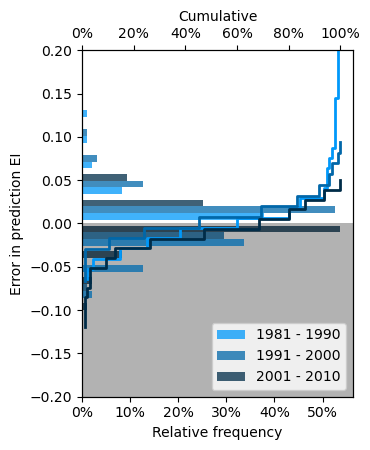

In [12]:
"Histogram EI deviations combined time periods (not overlapping) - ONE DECADE - cumulative"

import seaborn as sns
                          
fig = plt.figure()
fig.set_figheight(4.5)
fig.set_figwidth(3.5)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
                   
    

for j in range(len(yrsl)):  
    EI_dev_total = []        
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            EI_dev_total.append(EI_dev)   
                
    EI_dev_grouped[j-1] = EI_dev_total
    w[j-1] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:3]
w = w[0:3]
labels = yrsl[1:4]
c = colors[1:4]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev_grouped, bins=15, alpha = 0.75, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)

plt.legend(loc='lower right')

ax2 = plt.gca().twiny()

for i in range(len(EI_dev_grouped)):
    sns.histplot(data=EI_dev_grouped[i], element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, color=c[i], y = EI_dev_grouped[i], linewidth = 2, linestyle='solid')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax2.grid('false')
ax2.set_xlabel('Cumulative')

# print(EI_dev_grouped)
ax2.grid(False)
ax2.set_facecolor("None")

plt.savefig(f'2_Output/{output}/Histograms/Histogram_timeslices1.png')   


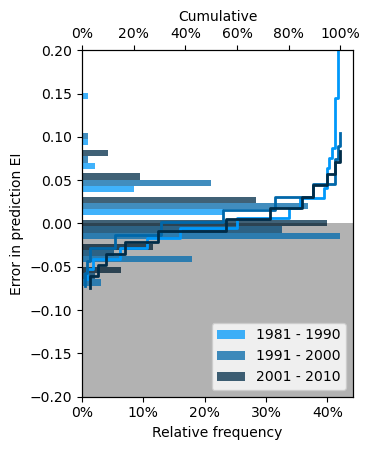

In [13]:
"Histogram EI deviations combined time periods (not overlapping) - PAST DECADE - cumulative"

import seaborn as sns
                          
fig = plt.figure()
fig.set_figheight(4.5)
fig.set_figwidth(3.5)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
                            

for j in range(len(yrsl)):  
    EI_dev_total = []        
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation past decades {yrsl[j]}']].item()
            EI_dev_total.append(EI_dev)   
                
    EI_dev_grouped[j-1] = EI_dev_total
    w[j-1] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:3]
w = w[0:3]
labels = yrsl[1:4]
c = colors[1:4]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev_grouped, bins=15, alpha = 0.75, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)

plt.legend(loc='lower right')

ax2 = plt.gca().twiny()

for i in range(len(EI_dev_grouped)):
    sns.histplot(data=EI_dev_grouped[i], element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, color=c[i], y = EI_dev_grouped[i], linewidth = 2)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax2.grid('false')
ax2.set_xlabel('Cumulative')

# print(EI_dev_grouped)
ax2.grid(False)
ax2.set_facecolor("None")

plt.savefig(f'2_Output/{output}/Histograms/Histogram_timeslices1.png')   

### Histogram EI deviations grouped by aridity (not overlapping)

([18001, 21017, 27047, 46003, 46005, 55008, 55026, 57004, 64001, 67010, 67018, 72005, 73005, 73011, 76014, 78004, 79002, 79004, 93001, 94001], [17005, 20007, 21024, 22001, 23004, 24004, 25006, 27035, 27042, 27051, 27071, 28046, 39020, 41022, 41027, 45005, 47009, 48003, 48004, 49004, 50002, 52010, 52016, 53009, 54008, 54025, 55014, 55016, 55029, 56013, 60002, 60003, 62001, 65005, 71001, 71004, 75017, 77004, 8009], [21023, 26003, 28072, 29003, 29009, 30004, 30012, 30015, 31023, 32003, 33018, 33019, 33029, 34011, 36003, 36009, 36010, 37005, 38026, 39017, 39019, 39025, 39034, 40005, 40011, 41025, 41029, 42003, 43014, 53006, 53008, 53017, 54018, 54034, 54036, 68005])
60 117 108


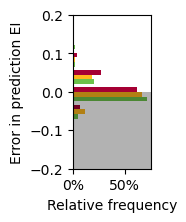

In [14]:
"Histogram EI deviations grouped by aridity (not overlapping)"

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"AI < 0.33", f"0.33 < AI < 0.66", f"0.66 < AI"]
                            
                
print(catchment_list_AI)
for a in range(len(catchment_list_AI)):
    catchment_list = catchment_list_AI[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                
# Label maken

des = 'AI'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_AI} (n={n1})", f"{cut1_AI} < {des} < {cut2_AI} (n={n2})", f"{des} > {cut2_AI} (n={n3})"]               
                
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors2[0:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation="horizontal")
plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation="horizontal")

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_aridity_notoverlapping_v1.png')   

### Histogram EI deviations grouped by seasonality index (not overlapping)

55
40
0
165 120 0


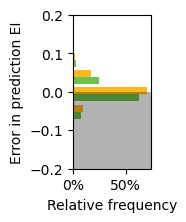

In [15]:
"Histogram EI deviations grouped by index (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"SI < {cut1_SI}",
          f"{cut1_SI} <= SI < {cut2_SI}",
          f"{cut2_SI} <= SI"]

print(len(catchment_list_SI[0]))
print(len(catchment_list_SI[1]))
print(len(catchment_list_SI[2]))

for a in range(len(catchment_list_SI)):
    catchment_list = catchment_list_SI[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                

# Label maken

des = 'SI'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_SI} (n={n1})", f"{cut1_SI} < {des} < {cut2_SI} (n={n2})", f"{des} > {cut2_SI} (n={n3})"]              
                
                
                
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_SI.png')   

### Histogram EI deviations grouped by seasonality timing (not overlapping)

([], [20007, 22001, 24004, 26003, 27051, 28046, 28072, 29003, 30004, 30012, 30015, 31023, 32003, 33018, 33029, 38026, 39017, 54008, 54018, 54034, 54036, 55014, 55029], [17005, 18001, 21017, 21023, 21024, 23004, 25006, 27035, 27042, 27047, 27071, 29009, 33019, 34011, 36003, 36009, 36010, 37005, 39019, 39020, 39025, 39034, 40005, 40011, 41022, 41025, 41027, 41029, 42003, 43014, 45005, 46003, 46005, 47009, 48003, 48004, 49004, 50002, 52010, 52016, 53006, 53008, 53009, 53017, 54025, 55008, 55016, 55026, 56013, 57004, 60002, 60003, 62001, 64001, 65005, 67010, 67018, 68005, 71001, 71004, 72005, 73005, 73011, 75017, 76014, 77004, 78004, 79002, 79004, 8009, 93001, 94001])
0
23
72
0 69 216


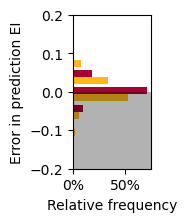

In [16]:
"Histogram EI deviations grouped by ST (not overlapping)"


fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", "", "", ""]
w = ["", "", "", "", ""]
labels = [f"ST < {cut1_ST}",
          f"{cut1_ST} <= ST < {cut2_ST}",
          f"{cut2_ST} <= ST"]

print(catchment_list_ST)

print(len(catchment_list_ST[0]))
print(len(catchment_list_ST[1]))
print(len(catchment_list_ST[2]))


                
for a in range(len(catchment_list_ST)):
    catchment_list = catchment_list_ST[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                

                
# Label maken

des = 'ST'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_ST} (n={n1})", f"{cut1_ST} < {des} < {cut2_ST} (n={n2})", f"{des} > {cut2_ST} (n={n3})"]                    
                
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:3]
w = w[1:3]
labels = labels[1:3]
c = colors2[1:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_ST_notoverlapping_v1.png')   

### Histogram EI deviations grouped by Interstorm duration (not overlapping)

([17005, 18001, 20007, 21017, 21023, 21024, 22001, 23004, 24004, 25006, 26003, 27035, 27042, 27047, 27051, 27071, 28046, 34011, 46003, 46005, 47009, 48003, 48004, 49004, 50002, 54008, 54018, 54025, 55008, 55014, 55016, 55026, 56013, 57004, 60002, 60003, 62001, 64001, 65005, 67010, 67018, 68005, 71001, 71004, 72005, 73005, 73011, 75017, 76014, 77004, 78004, 79002, 79004, 8009, 93001, 94001], [28072, 29003, 29009, 30004, 30012, 30015, 31023, 32003, 33018, 33019, 33029, 36003, 36009, 36010, 37005, 38026, 39017, 39019, 39020, 39025, 39034, 40005, 40011, 41022, 41025, 41027, 41029, 42003, 43014, 45005, 52010, 52016, 53006, 53008, 53009, 53017, 54034, 54036, 55029], [])
168 117 0
56
39
0


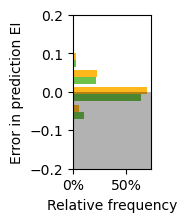

In [17]:
"Histogram EI deviations grouped by interstorm (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"Is_dur < {cut1_isdur}",
          f"{cut1_isdur} <= Is_dur < {cut2_isdur}",
          f"{cut2_isdur} <= Is_dur"]

print(catchment_list_isdur)



# Dit kan je weer hetzelfde laten (alleen bins aanpassen)

for a in range(len(catchment_list_isdur)):
    catchment_list = catchment_list_isdur[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                

                
# Label maken

des = 'is_dur'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_isdur} (n={n1})", f"{cut1_isdur} < {des} < {cut2_isdur} (n={n2})", f"{des} > {cut2_isdur} (n={n3})"]             
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_isdur_notoverlapping_v1.png')   

print(len(catchment_list_isdur[0]))
print(len(catchment_list_isdur[1]))
print(len(catchment_list_isdur[2]))

### Histogram EI deviations grouped by Mean annual values (not overlapping)

([21023, 28072, 29009, 30012, 30015, 31023, 32003, 33018, 33019, 33029, 36003, 36009, 36010, 37005, 38026, 39017], [17005, 20007, 21024, 22001, 23004, 24004, 25006, 26003, 27035, 27042, 27051, 27071, 28046, 29003, 30004, 34011, 39019, 39020, 39025, 39034, 40005, 40011, 41022, 41025, 41027, 41029, 42003, 43014, 45005, 47009, 48003, 49004, 50002, 52010, 52016, 53006, 53008, 53009, 53017, 54008, 54018, 54025, 54034, 54036, 55014, 55016, 55029, 56013, 68005, 71001, 71004, 75017, 77004, 8009], [18001, 21017, 27047, 46003, 46005, 48004, 55008, 55026, 57004, 60002, 60003, 62001, 64001, 65005, 67010, 67018, 72005, 73005, 73011, 76014, 78004, 79002, 79004, 93001, 94001])
48 162 75
16
54
25


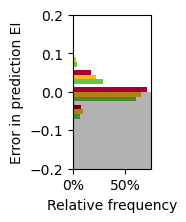

In [18]:
"Histogram EI deviations grouped by P (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"P < {cut1_Pa}",
          f"{cut1_Pa} <= P < {cut2_Pa}",
          f"{cut2_Pa} <= P"]

print(catchment_list_Pa)
for a in range(len(catchment_list_Pa)):
    catchment_list = catchment_list_Pa[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                

# Label maken

des = 'P'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_Pa} (n={n1})", f"{cut1_Pa} < {des} < {cut2_Pa} (n={n2})", f"{des} > {cut2_Pa} (n={n3})"]                            
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors2[0:3]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_Pa_notoverlapping_v1.png')   

print(len(catchment_list_Pa[0]))
print(len(catchment_list_Pa[1]))
print(len(catchment_list_Pa[2]))

54 231 0
([17005, 18001, 20007, 21017, 21024, 23004, 25006, 27047, 72005, 75017, 76014, 77004, 78004, 79002, 79004, 8009, 93001, 94001], [21023, 22001, 24004, 26003, 27035, 27042, 27051, 27071, 28046, 28072, 29003, 29009, 30004, 30012, 30015, 31023, 32003, 33018, 33019, 33029, 34011, 36003, 36009, 36010, 37005, 38026, 39017, 39019, 39020, 39025, 39034, 40005, 40011, 41022, 41025, 41027, 41029, 42003, 43014, 45005, 46003, 46005, 47009, 48003, 48004, 49004, 50002, 52010, 52016, 53006, 53008, 53009, 53017, 54008, 54018, 54025, 54034, 54036, 55008, 55014, 55016, 55026, 55029, 56013, 57004, 60002, 60003, 62001, 64001, 65005, 67010, 67018, 68005, 71001, 71004, 73005, 73011], [])
18
77
0


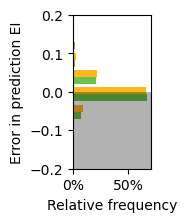

In [19]:
"Histogram EI deviations grouped by Ep (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"Ep < {cut1_Epa}",
          f"{cut1_Epa} <= Ep < {cut2_Epa}",
          f"{cut2_Epa} <= Ep"]

for a in range(len(catchment_list_Epa)):
    catchment_list = catchment_list_Epa[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
                EI_dev_grouped[a] = EI_dev_total
                w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                

                
# Label maken

des = 'Ep'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_Epa} (n={n1})", f"{cut1_Epa} < {des} < {cut2_Epa} (n={n2})", f"{des} > {cut2_Epa} (n={n3})"]                    
                
                
                
# Hier invullen welke niet arrays niet leeg zijn
print(catchment_list_Epa)
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_Ep_notoverlapping_v1.png')   

print(len(catchment_list_Epa[0]))
print(len(catchment_list_Epa[1]))
print(len(catchment_list_Epa[2]))

246 39 0
([17005, 18001, 20007, 21017, 21023, 21024, 22001, 23004, 24004, 25006, 26003, 27035, 27042, 27047, 27051, 27071, 28046, 28072, 29003, 29009, 30004, 30012, 30015, 31023, 32003, 33018, 33019, 33029, 34011, 36009, 36010, 38026, 39017, 39019, 39020, 39025, 39034, 41027, 43014, 45005, 46003, 46005, 48004, 50002, 52016, 53008, 53009, 53017, 54008, 54018, 54025, 54034, 54036, 55008, 55014, 55016, 55026, 55029, 56013, 57004, 60002, 60003, 62001, 64001, 65005, 67010, 67018, 68005, 71001, 71004, 72005, 73005, 73011, 75017, 76014, 77004, 78004, 79002, 79004, 8009, 93001, 94001], [36003, 37005, 40005, 40011, 41022, 41025, 41029, 42003, 47009, 48003, 49004, 52010, 53006], [])
82
13
0


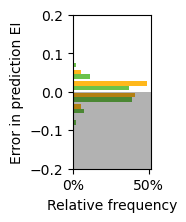

In [30]:
"Histogram EI deviations grouped by T (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = ["", "", ""]
w = ["", "", ""]
labels = [f"T < {cut1_T}",
          f"{cut1_T} <= T < {cut2_T}",
          f"{cut2_T} <= T"]

for a in range(len(catchment_list_T)):
    catchment_list = catchment_list_T[a]
    EI_dev_total = []        
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                
            EI_dev_grouped[a] = EI_dev_total
            w[a] = np.ones_like(EI_dev_total)/(len(EI_dev_total))
                
                
                

                
# Label maken

des = 'T'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_T} (n={n1})", f"{cut1_T} < {des} < {cut2_T} (n={n2})", f"{des} > {cut2_T} (n={n3})"]                        
                
                
# Hier invullen welke niet arrays niet leeg zijn
print(catchment_list_T)
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]

# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
# plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.hist(EI_dev_grouped, bins=15, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')

plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_T_notoverlapping_v1.png')   

print(len(catchment_list_T[0]))
print(len(catchment_list_T[1]))
print(len(catchment_list_T[2]))

## Change vs change

### Aridity

66 196 23
-0.15514521475941423
0.13832787702840643


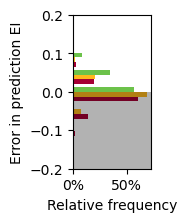

In [21]:
" Change vs change: aridity"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_GB
    

change1 = -0.05
change2 = 0.05    
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'AI'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Precipitation

42 57 186
-184.64900000000034
299.77333333333354


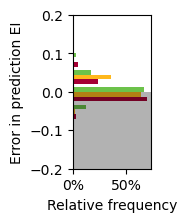

In [22]:
" Change vs change: precipitation"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_GB
    

change1 = -20
change2 = 20
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'Pa'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Evaporation

0 197 87
-10.022851384990247
39.45760572704012


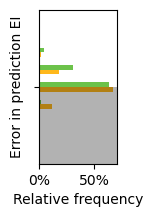

In [23]:
" Change vs change: evaporation"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_GB
    

change1 = -10
change2 = 10
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'Epa'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)

EI_dev1 = ''                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0 and EI_dev[a] != '':
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Temperature

0 97 188
-0.0908453854040685
0.6110082029834416


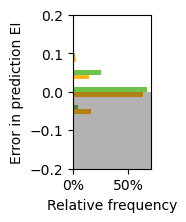

In [24]:
" Change vs change: temperature"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_GB
    

change1 = -0.2
change2 = 0.2
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'T'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Interstorm duration

132 98 55
-0.6172554500418035
0.5756688963210701


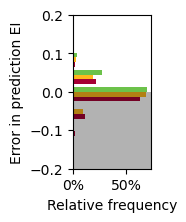

In [25]:
" Change vs change: interstorm duration"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_GB
    

change1 = -0.1
change2 = 0.1
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'is_dur'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/ISdur_change.png')   

## Seasonality index

73 112 100
-0.1119687627752276
0.08534751944302235


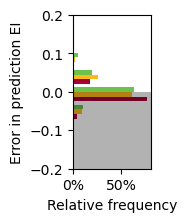

In [26]:
" Change vs change: Seasonality index"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_GB
    

change1 = -0.02
change2 = 0.02
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'SI'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Seasonality Timing

62 72 151
-0.17508039163017108
0.19570503108285478


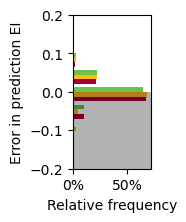

In [27]:
" Change vs change: Seasonality index"

fig, axs = plt.subplots(1, 1)
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)

catchment_list = catchment_list_GB
    

change1 = -0.02
change2 = 0.02
    
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'ST'


w = ["", "", ""]


for j in range(len(yrsl)):  
    if j > 0:
        for i in range(len(catchment_list)):
            des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
            des_change_total.append(des_change)
            if des_change < change1:
                des_change1.append(des_change)
                EI_dev1.append(EI_dev)    
            elif change1 <= des_change and des_change < change2:
                des_change2.append(des_change)
                EI_dev2.append(EI_dev)
            elif change2 <= des_change:
                des_change3.append(des_change)
                EI_dev3.append(EI_dev)
                
                
EI_dev = EI_dev1, EI_dev2, EI_dev3

n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)
        
        
labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]


# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  


# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=10, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            


# plt.legend(loc='lower right')

                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   

## Plot correlations

In [ ]:
for k in range(len(descriptors)):
    plt.suptitle('CAMELS GB')
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(5)
    fig.set_figwidth(7)
    
    EI_dev_total = []
    des_change_total = []
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                            
                plt.plot(df_output[f'{descriptors[k]}_change {yr}'], df_output[f'EI deviation {yrsl[j]}'], '.', c=colors[j])      

    x = des_change_total
    y = EI_dev_total
    
    pearson = pearsonr(x, y)
    m, b = np.polyfit(x, y, 1)
    pearsony = np.zeros(len(x))
    
    for q in range(len(EI_dev_total)):
        pearsony[q] = m * x[q] + b
    axs.plot(x, pearsony, 'k')
                
        
    axs.set_xlabel(f"Change in {descriptors_names[k]}")
    axs.set_ylabel(f"Devation Evaporative Index")
    axs.set_title(f"CAMELS GB {descriptors_names[k]}")
    
    
    legend = [Line2D([0], [0], marker='.', color='gainsboro', label=f'{yrsl[1]}',
                       markerfacecolor=f'{colors[1]}', markersize=15),
              Line2D([0], [0], marker='.', color='gainsboro', label=f'{yrsl[2]}',
                       markerfacecolor=f'{colors[2]}', markersize=15),
             Line2D([0], [0], color='k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" ,
                       markerfacecolor='k', markersize=10)]                    

    axs.legend(handles=legend,loc='lower right')
                
    plt.savefig(f'2_Output/{output}/Results/Correlations_total{descriptors_names[k]}.png')   
    plt.close()

### Plot correlations for seperate time periods

In [ ]:
for k in range(len(descriptors)):
    n_tot = len(yrsl) - 1 
    fig, axs = plt.subplots(1, n_tot)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    plt.suptitle('CAMELS GB')
    for j in range(len(yrsl)):
        if j > 0:
            yr = yrsl[j]
            c = colors[j]
            n = j - 1
            
            for c in range(len(df_output)):
                axs[n].plot(df_output[f'{descriptors[k]}_change {yr}'], df_output[f'EI deviation {yr}'], '.')      

            x = df_output[f'{descriptors[k]}_change {yr}']
            y = df_output[f'EI deviation {yr}']

                
            pearson = pearsonr(x, y)

            m, b = np.polyfit(x, y, 1)
            axs[n].plot(x, m*x + b, 'k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" )
            axs[n].legend(loc='lower right')
                
                
            axs[n].set_xlabel(f"Change in {descriptors_names[k]}")
            axs[n].set_ylabel(f"Devation Evaporation Index")
            axs[n].set_title(f"Change in {descriptors_names[k]} period of {yr}")
    plt.savefig(f'2_Output/{output}/Results/Correlations_per_slice{descriptors_names[k]}.png')   
    plt.close(fig)

## Plot EI expected

In [ ]:
catchment_list = catchment_list_GB

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv('1_Data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/timeseries/CAMELS_GB_hydromet_timeseries_'+str(catchment_list[i])+str("_19701001-20150930.csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['date'])
    data.index = data['dt']
    data = data[3379:-273]
    
    # Compute the Makkink potential evaporation
    Eref = calc_Makkink_GB(data['temperature'],data['shortwave_rad'])
    data['Ep_MAK'] = Eref
            
    # Compute mean values    
    Ep = data['Ep_MAK'].mean()    
    T = data['temperature'].mean()
    P  = data['precipitation'].mean()
    Q  = data['discharge_spec'].mean()
        
    # Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  
    AI = Ep / P   
    EI = Ea / P    
        
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['date']).year  
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['Ep_MAK'].mean()    
        T = datanew['temperature'].mean()
        P  = datanew['precipitation'].mean()
        Q  = datanew['discharge_spec'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)
        
        if j > 0:
            c_exp = colors[j-1]
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            axs[0].plot(AI, EI_exp, marker='d', color=c, markersize=5)
            
        # Calculate root zone storage deficits
        RP    = 20 # Return-period of 20 years
        P_ts  = datanew['precipitation']
        EP_ts = datanew['Ep_MAK']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}'),
                Line2D([0], [0], color=colors[2], lw=1, label=f'{yrsl[2]}')]
                       

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)